<a href="https://colab.research.google.com/github/riviera2015/MOLFARES/blob/master/JANSEN_TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

## Run inside docker container for GPU acceleration

See [tensorflow guide](https://www.tensorflow.org/install/docker) and more detailed [instructions](https://blog.sicara.com/tensorflow-gpu-opencv-jupyter-docker-10705b6cd1d)

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/18_recurrent_neural_nets:/rnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

Inside docker container: 
`jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`

In [1]:
!pip install google

## Imports & Settings

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

In [34]:
sns.set_style('whitegrid')
np.random.seed(42)

## Get Data

We obtain data for 2010-2018 from the Federal Reserve Bank’s Data Service [FRED](https://fred.stlouisfed.org/) using the [pandas_datareader](https://pandas-datareader.readthedocs.io/) library in introduced in [Chapter 2 on Market and Fundamental Data](../02_market_and_fundamental_data).

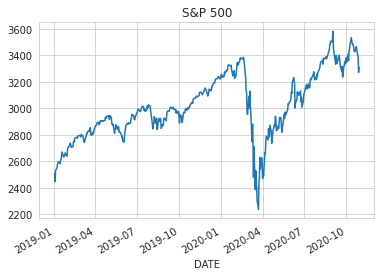

In [37]:
sp500 = web.DataReader('SP500', 'fred', start='2019', end='2021').dropna()
sp500.plot(title='S&P 500', legend=False);

## Preprocessing

In [38]:
scaler = MinMaxScaler()

In [39]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

count    462.000000
mean       0.578503
std        0.184366
min        0.000000
25%        0.459885
50%        0.556445
75%        0.732353
max        1.000000
dtype: float64

## Generating recurrent sequences from our time series

Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

<img src="images/timeseries_windowing.gif" width=600 height=600/>

We will generate sequences of 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

Our S&P 500 sample has 2,264 observations or time steps. We will create overlapping sequences using a window of 63 observations each.
For a simpler window of size T = 5, we obtain input-output pairs as shown in the following table:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_1,x_2,x_3,x_4,x_5\rangle} & { x_6} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & {x_{7} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-5},x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [40]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [41]:
window_size = 63

In [42]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [43]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-03,0.202934,0.156680,0.219243,0.232455,0.250856,0.258709,0.267403,0.267120,0.256960,0.277571,0.281888,0.296671,0.322538,0.294393,0.298711,0.301413,0.318109,0.302544,0.299678,0.330234,0.347392,0.349201,0.362852,0.372402,0.367869,0.348843,0.350205,0.351635,0.377635,0.383813,0.378379,0.400613,0.403710,0.407387,0.400077,0.413320,0.415880,0.414235,0.413104,0.407231,0.421522,0.413424,0.411072,0.397524,0.380761,0.376399,0.406345,0.412464,0.426904,0.425088,0.435509,0.443295,0.443019,0.436811,0.459626,0.419304,0.417555,0.432517,0.422773,0.430269,0.444382,0.468789,0.468826
2019-04-04,0.156680,0.219243,0.232455,0.250856,0.258709,0.267403,0.267120,0.256960,0.277571,0.281888,0.296671,0.322538,0.294393,0.298711,0.301413,0.318109,0.302544,0.299678,0.330234,0.347392,0.349201,0.362852,0.372402,0.367869,0.348843,0.350205,0.351635,0.377635,0.383813,0.378379,0.400613,0.403710,0.407387,0.400077,0.413320,0.415880,0.414235,0.413104,0.407231,0.421522,0.413424,0.411072,0.397524,0.380761,0.376399,0.406345,0.412464,0.426904,0.425088,0.435509,0.443295,0.443019,0.436811,0.459626,0.419304,0.417555,0.432517,0.422773,0.430269,0.444382,0.468789,0.468826,0.473412
2019-04-05,0.219243,0.232455,0.250856,0.258709,0.267403,0.267120,0.256960,0.277571,0.281888,0.296671,0.322538,0.294393,0.298711,0.301413,0.318109,0.302544,0.299678,0.330234,0.347392,0.349201,0.362852,0.372402,0.367869,0.348843,0.350205,0.351635,0.377635,0.383813,0.378379,0.400613,0.403710,0.407387,0.400077,0.413320,0.415880,0.414235,0.413104,0.407231,0.421522,0.413424,0.411072,0.397524,0.380761,0.376399,0.406345,0.412464,0.426904,0.425088,0.435509,0.443295,0.443019,0.436811,0.459626,0.419304,0.417555,0.432517,0.422773,0.430269,0.444382,0.468789,0.468826,0.473412,0.477870
2019-04-08,0.232455,0.250856,0.258709,0.267403,0.267120,0.256960,0.277571,0.281888,0.296671,0.322538,0.294393,0.298711,0.301413,0.318109,0.302544,0.299678,0.330234,0.347392,0.349201,0.362852,0.372402,0.367869,0.348843,0.350205,0.351635,0.377635,0.383813,0.378379,0.400613,0.403710,0.407387,0.400077,0.413320,0.415880,0.414235,0.413104,0.407231,0.421522,0.413424,0.411072,0.397524,0.380761,0.376399,0.406345,0.412464,0.426904,0.425088,0.435509,0.443295,0.443019,0.436811,0.459626,0.419304,0.417555,0.432517,0.422773,0.430269,0.444382,0.468789,0.468826,0.473412,0.477870,0.487807
2019-04-09,0.250856,0.258709,0.267403,0.267120,0.256960,0.277571,0.281888,0.296671,0.322538,0.294393,0.298711,0.301413,0.318109,0.302544,0.299678,0.330234,0.347392,0.349201,0.362852,0.372402,0.367869,0.348843,0.350205,0.351635,0.377635,0.383813,0.378379,0.400613,0.403710,0.407387,0.400077,0.413320,0.415880,0.414235,0.413104,0.407231,0.421522,0.413424,0.411072,0.397524,0.380761,0.376399,0.406345,0.412464,0.426904,0.425088,0.435509,0.443295,0.443019,0.436811,0.459626,0.419304,0.417555,0.432517,0.422773,0.430269,0.444382,0.468789,0.468826,0.473412,0.477870,0.487807,0.490063


In [13]:
y.tail()

DATE
2020-10-23    0.953478
2020-10-26    0.927519
2020-10-27    0.923372
2020-10-28    0.875158
2020-10-29    0.890906
dtype: float64

In [12]:
X.shape

(2454, 63)

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

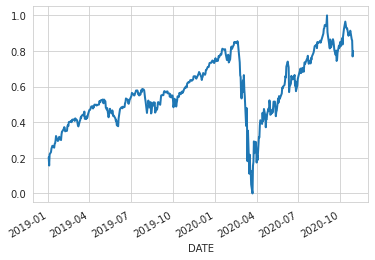

In [44]:
sp500_scaled.plot(lw=2);

In [45]:
X_train = X[:'2019'].values.reshape(-1, window_size, 1)
y_train = y[:'2019']

# keep the last year for testing
X_test = X['2020'].values.reshape(-1, window_size, 1)
y_test = y['2020']

In [46]:
n_obs, window_size, n_features = X_train.shape

In [47]:
y_train.shape

(189,)

## Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

```
LSTM(units,
     activation='tanh',
     recurrent_activation='hard_sigmoid',
     use_bias=True,
     kernel_initializer='glorot_uniform',
     recurrent_initializer='orthogonal',
     bias_initializer='zeros',
     unit_forget_bias=True,
     kernel_regularizer=None,
     recurrent_regularizer=None,
     bias_regularizer=None,
     activity_regularizer=None,
     kernel_constraint=None,
     recurrent_constraint=None,
     bias_constraint=None,
     dropout=0.0,
     recurrent_dropout=0.0,
     implementation=1,
     return_sequences=False,
     return_state=False,
     go_backwards=False,
     stateful=False,
     unroll=False)
 ```

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [48]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

The summary shows that the model has 1,781 parameters:

In [19]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [49]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [50]:
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes. 

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=50,
                              restore_best_weights=True)

In [52]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=0)

Training stops after 51 epochs; the `early_stopping` callback restores the weights for the best model (after 41 epochs)

## Evaluate model performance

The following charts illustrate the out-of-sample forecast performance that generally track the index development in 2018 well with a test RMSE of 0.015 on the rescaled price series. The test IC is 95.85%. 

The loss history shows how the model’s validation error converges to an error level that illustrates the noise inherent in predicting stock prices:

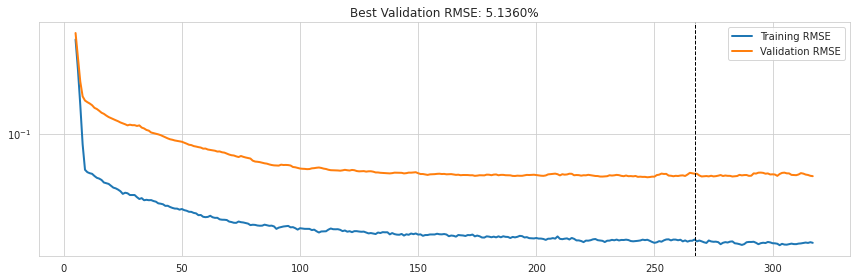

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))
loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()
best_epoch = loss_history.val_loss.idxmin()
loss_history.columns=['Training RMSE', 'Validation RMSE']
title = f'Best Validation RMSE: {best_rmse:.4%}'
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)
ax.axvline(best_epoch, ls='--', lw=1, c='k')
fig.tight_layout()
fig.savefig('rnn_sp500_error', dpi=300);

In [54]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0197 | Test RMSE: 0.0514


In [55]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

In [56]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9553 | Test IC: 0.9715


### Rescale predictions

In [57]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [58]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [59]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 26.41 | Test RMSE: 69.00'

In [60]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

### Plot Results

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


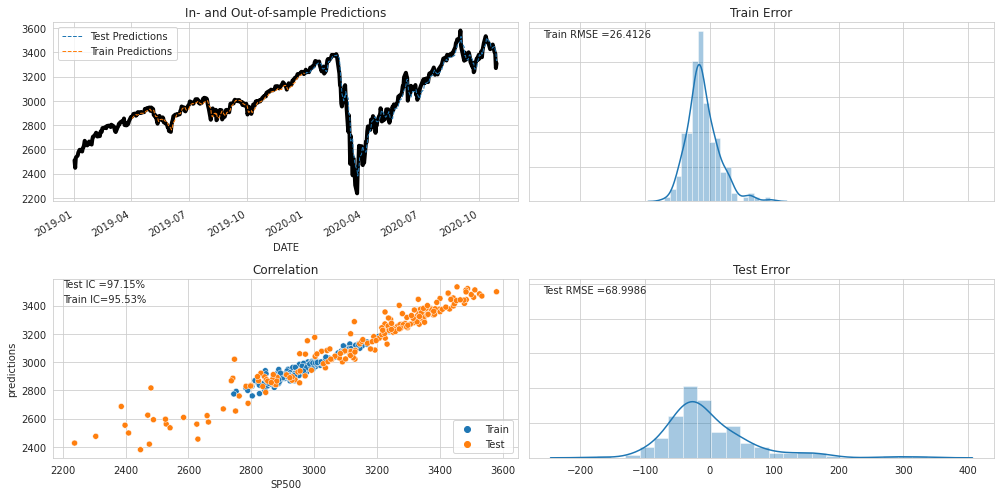

In [61]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)

sp500.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
ax3.set_title('Correlation')
ax3.legend(loc='lower right')

sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
ax2.set_title('Train Error')
ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
ax4.set_title('Test Error')
ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

fig.tight_layout()
fig.savefig('rnn_sp500_regression', dpi=300);